# Math 407 Project

1. Find a procedure for sampling uniformly on the surface of the sphere. 

**Part (a):** Use computer to generate a thousand points that are random, independent, and uniform on the unit sphere, and print the resulting picture.

**Algorithm**:

- Use random.randn in numpy library to generate (3,1000) arrays
- Use linalg.norm in numpy library to generate normalize the values 
- plot the figure in the following

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
from mpl_toolkits.mplot3d import axes3d

In [8]:
num_points = 1000

In [3]:
# first method (http://corysimon.github.io/articles/uniformdistn-on-sphere/)
def generate_points(num_points):
    npoints = np.random.uniform(0.0,1.0,num_points)
    theta = 2 * np.pi * npoints 
    phi = np.arccos(1 - 2 * npoints)
    x = np.multiply(np.sin(theta), np.cos(phi))
    y = np.multiply(np.sin(theta), np.sin(phi))
    z = np.multiply(np.cos(theta), np.ones_like(phi))
    return x, y, z

In [9]:
# second method generate (https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere)
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

In [10]:
def plot_sphere(xi, yi, zi): 
    phi = np.linspace(0, np.pi, 20)
    theta = np.linspace(0, 2 * np.pi, 40)
    x = np.outer(np.sin(theta), np.cos(phi))
    y = np.outer(np.sin(theta), np.sin(phi))
    z = np.outer(np.cos(theta), np.ones_like(phi))
    
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'equal'})
    ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
    ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)
    fig.set_figheight(15)
    fig.set_figwidth(15)

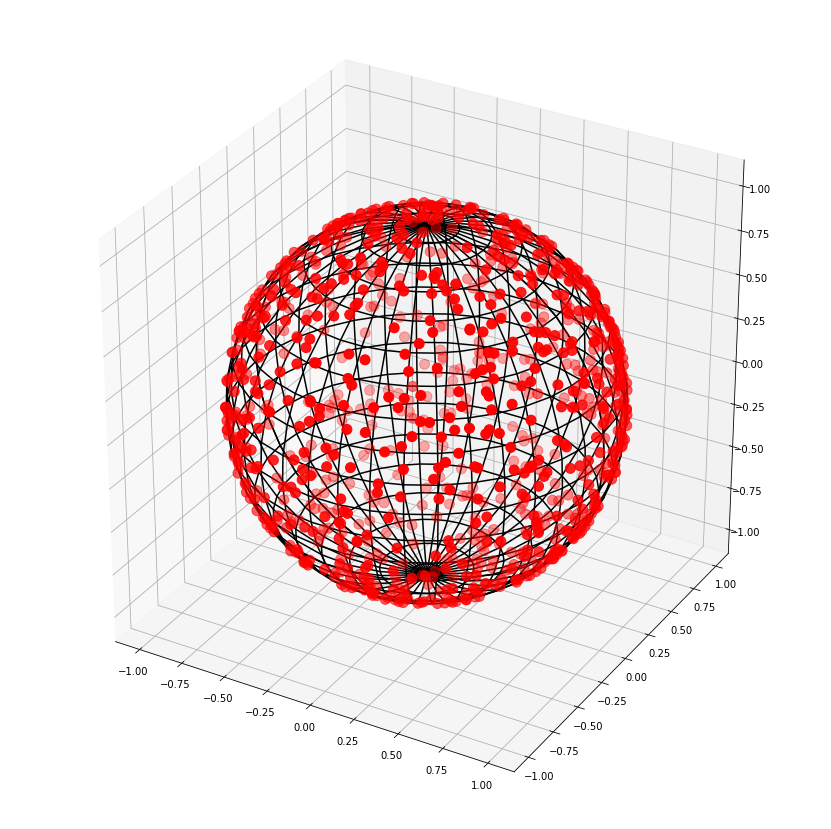

In [11]:
# first method plot: 
xi, yi, zi = sample_spherical(num_points, 3)
plot_sphere(xi, yi, zi)

In [40]:
my_data = np.genfromtxt('/Users/apple/Downloads/correct.csv', delimiter=',')
my_data = my_data[1:]
my_data.shape

(1000, 5)

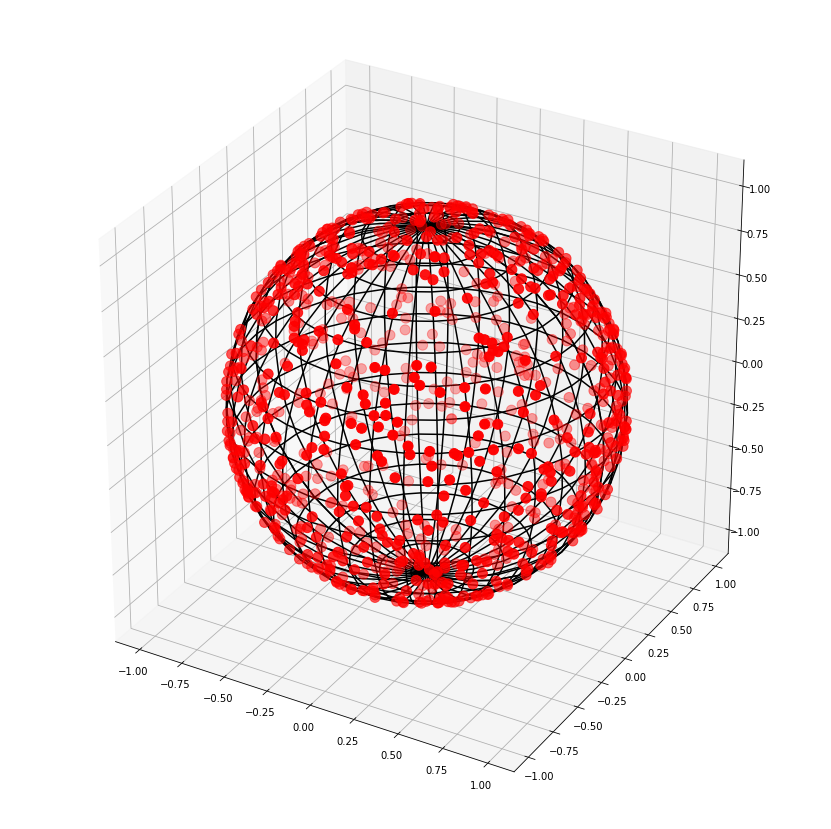

In [41]:
plot_sphere(my_data[:,2], my_data[:,3], my_data[:,4])

**Part (b):** By putting sufficiently many independent uniform points on the surface of the Earth (not literally but using a computer model, of course), estimate the areas of Antarctica and Africa, compare your results with the actual values, and make a few comments (e.g. are the relative errors similar? would you expect them to be similar? if not, which one should be bigger? etc.)

In [1]:
import fiona
import geopandas
import pandas as pd
import requests, zipfile, io
from shapely.ops import unary_union
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon

In [2]:
def get_dataframe(name):
    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[world.continent == name]
    continents = world.dissolve(by='continent')
    return continents

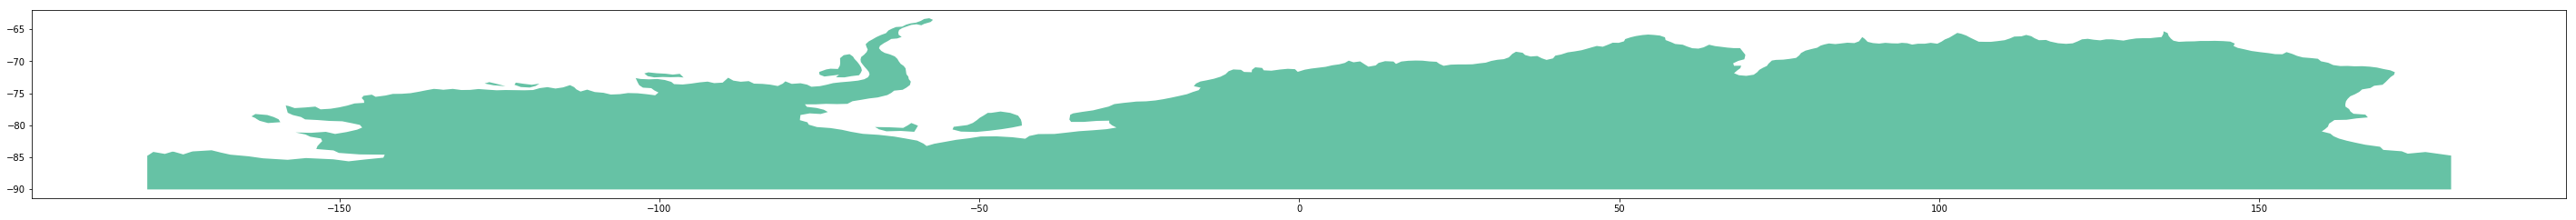

In [19]:
df_antarctica = get_dataframe('Antarctica')
df_antarctica.plot(cmap='Set2', figsize=(50, 50))

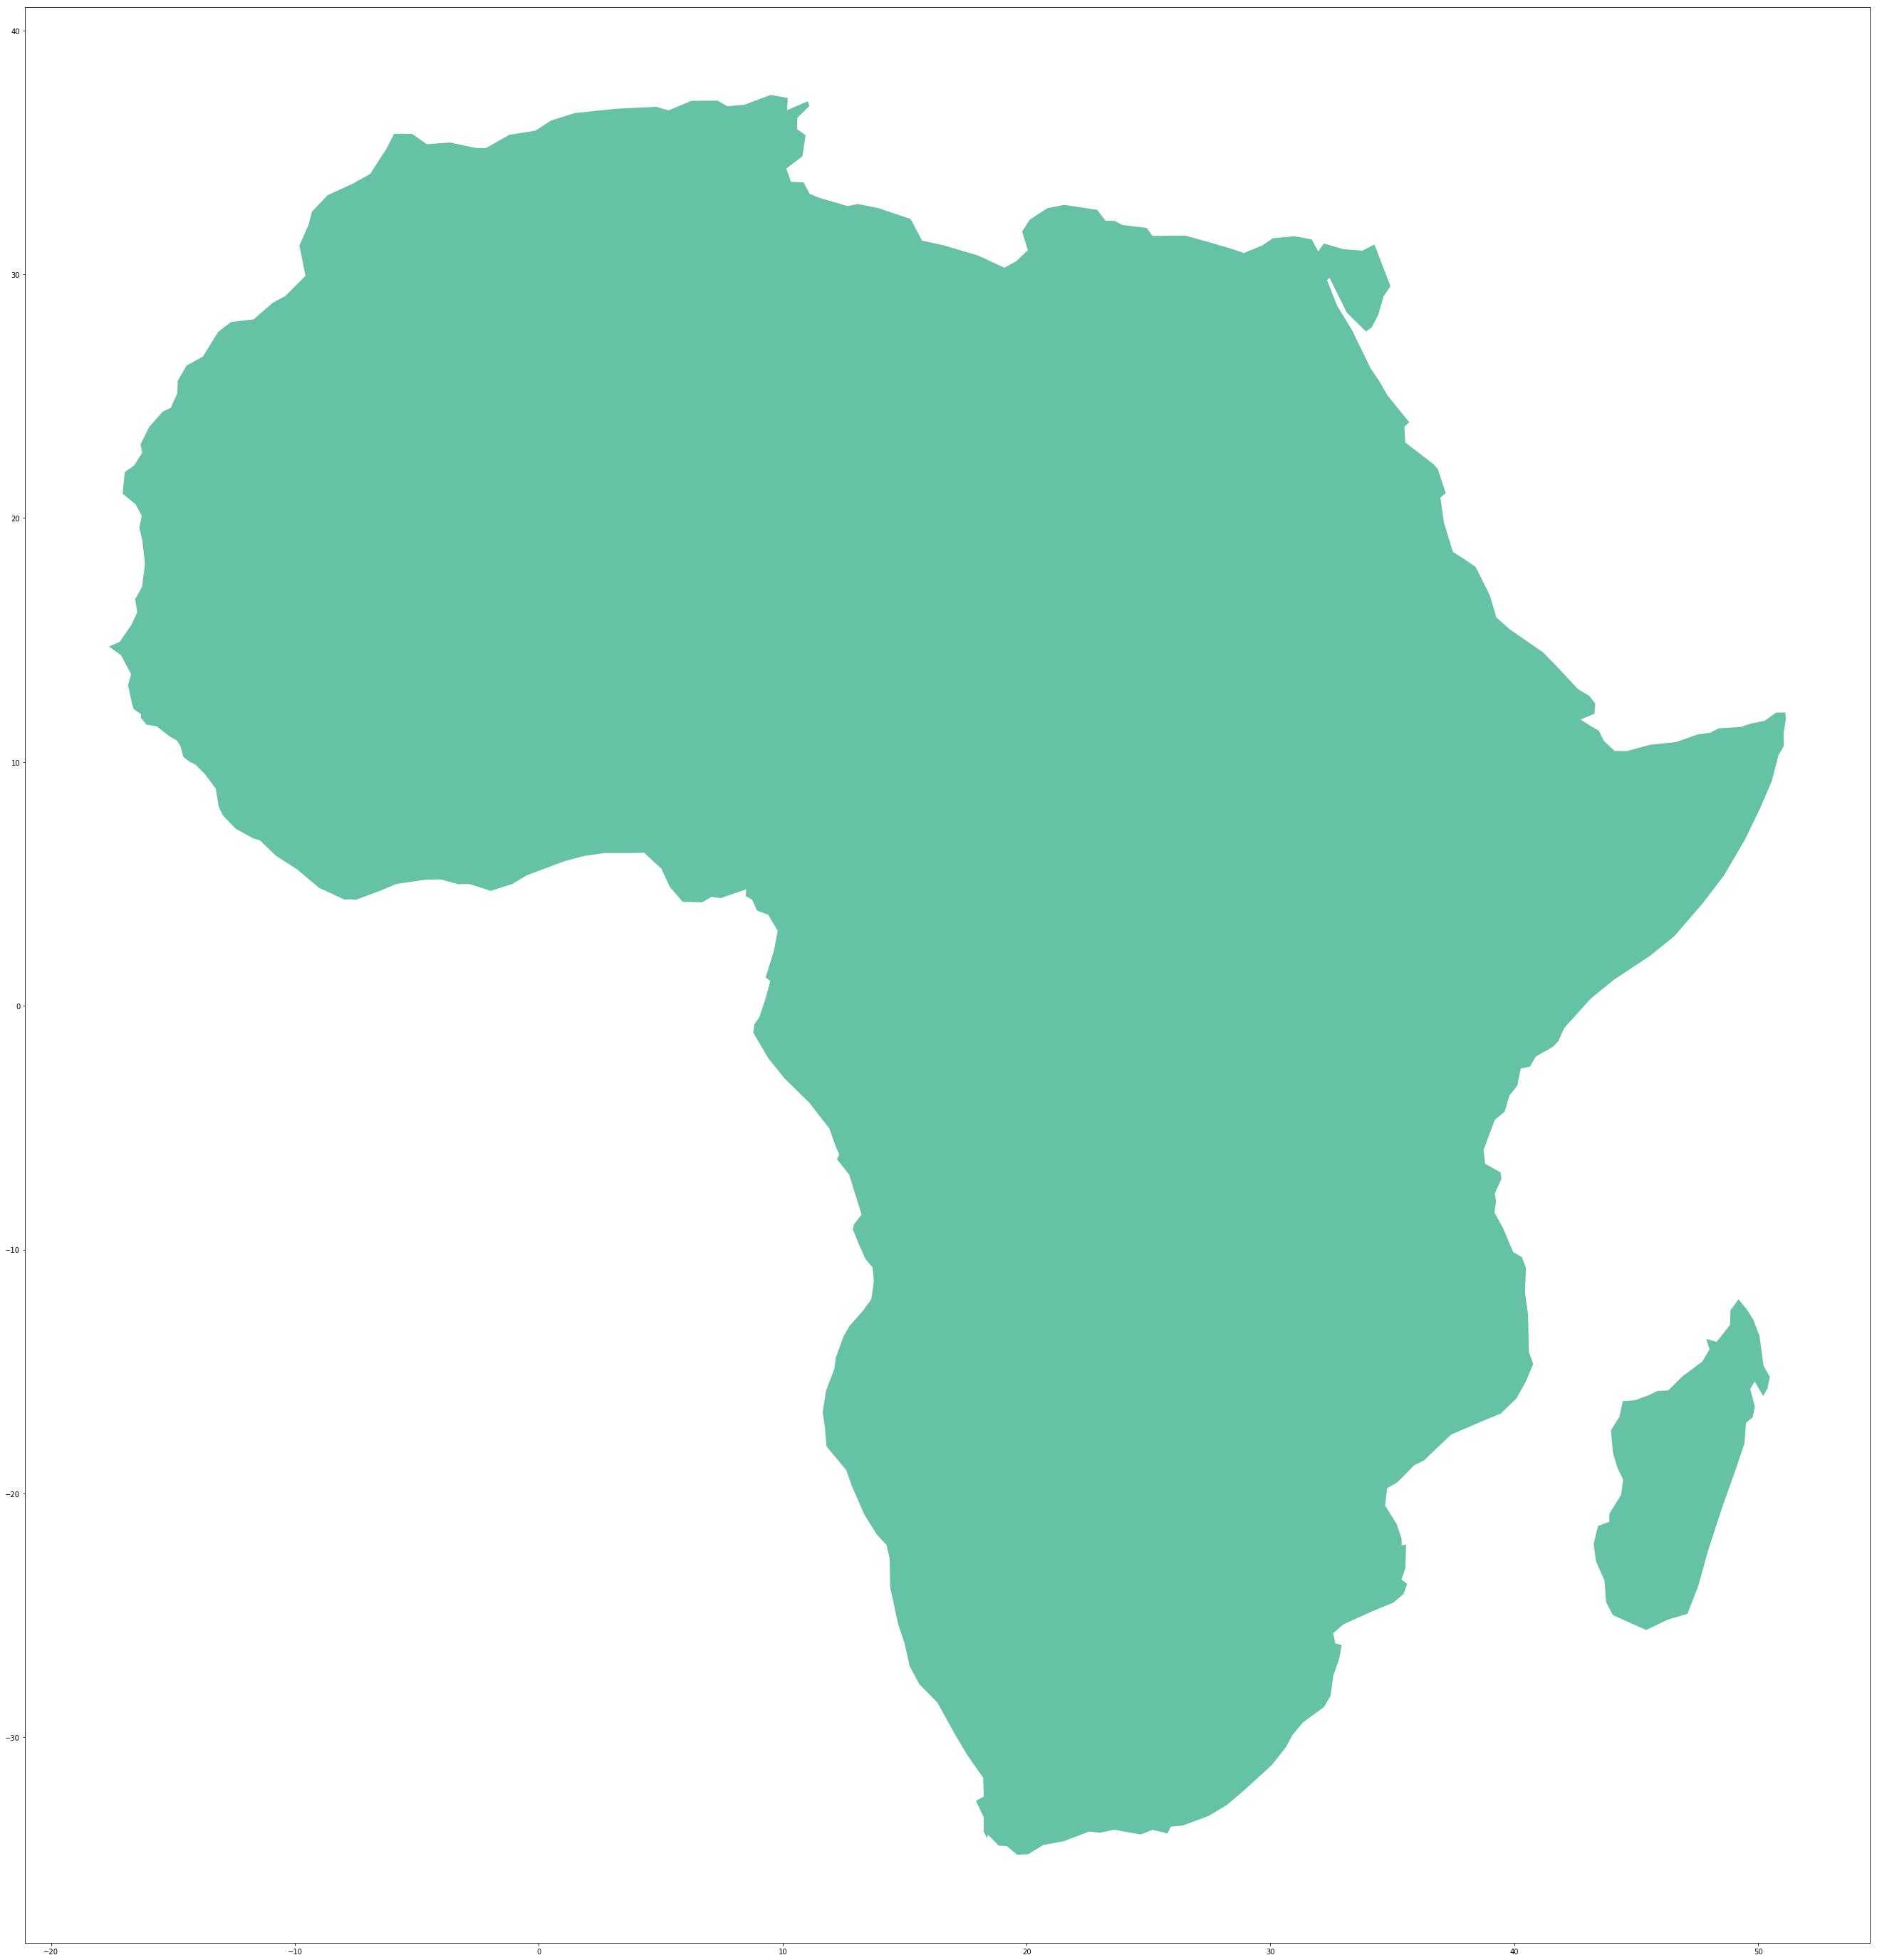

In [20]:
df_africa = get_dataframe('Africa')
df_africa.plot(cmap='Set2', figsize=(50,50))

In [13]:
# transformation 1 (converting spherical coordinates to longitude and latitude): written by yuyangh
def transformation1(theta, phi):
    longitude = np.zeros((1000, ))
    latitude = np.zeros((1000, ))
    # initialize values for longitude and latitude 

    phi = my_data[:,1]
    theta = my_data[:,0]
    for i in range(1000):
        if theta[i] < np.pi:
            longitude[i] = - (180 - theta[i] / np.pi * 180)
        else:
            longitude[i] = (theta[i] - np.pi) / np.pi * 180

        if phi[i] < 0.5 * np.pi:
            latitude[i] = (90 - phi[i] / np.pi * 180)
        else:
            latitude[i] = - (phi[i] - 0.5 * np.pi) / np.pi * 180
    return longitude, latitude

In [21]:
# transformation 2 (converting carteisan coordiantes to longitude and latitude): (https://gis.stackexchange.com/questions/120679/equations-to-convert-from-global-cartesian-coordinates-to-geographic-coordinates)
def transformation2(npoints, r, x, y, z): 
    longitude = np.zeros((npoints, ))
    latitude = np.multiply(np.arcsin(z / r), (180/np.pi))
    for i in range(longitude.shape[0]):
        if x[i] > 0:
            longitude[i] = np.multiply(np.arctan(y[i]/x[i]), (180/np.pi))
        elif y[i] > 0:
            longitude[i] = np.multiply(np.arctan(y[i]/x[i]), (180/np.pi)) + 180
        else:
            longitude[i] = np.multiply(np.arctan(y[i]/x[i]), (180/np.pi)) - 180
    return longitude, latitude
    

In [42]:
longitude, latitude = transformation2(1000, 1, my_data[:,2], my_data[:,3], my_data[:,4])

In [43]:
def generate_points_dataframe(longitude, latitude): 
    # create a pandas.DataFrame for storing longitude and latitude 
    dataframe = pd.DataFrame({
        'Latitude': latitude,
        'Longitude': longitude
    })
    # create a column name 'geometry' that encompasses longitude and latitude
    dataframe['geometry'] = list(zip(dataframe.Longitude, dataframe.Latitude))
    # convert entries under 'geometry' to type shapely.geometry.point.Point
    dataframe['geometry'] = dataframe['geometry'].apply(Point)
    # create a geopandas.GeoDataFrame converted from the pandas.DataFrame above
    points = geopandas.GeoDataFrame(dataframe, geometry='geometry')
    return points

In [44]:
points = generate_points_dataframe(longitude, latitude)

In [45]:
def count_points(name):
    if name == 'Antarctica': 
        iswithin = points['geometry'].within(df_antarctica['geometry'].values[0])
        return np.count_nonzero(iswithin)
    elif name == 'Africa': 
        iswithin = points['geometry'].within(df_africa['geometry'].values[0])
        return np.count_nonzero(iswithin)

In [46]:
area_earth = 196.9 
area_antarctica = 5.045
area_africa = 11.73

In [47]:
cnt_antarctica = count_points('Antarctica')
approx_area_antarctica = cnt_antarctica / num_points * area_earth 
error_antarctica = abs(approx_area_antarctica - area_antarctica) / area_antarctica 
print ("error in estimation of the area of Antarctica:", error_antarctica)

error in estimation of the area of Antarctica: 0.05377601585728446


In [48]:
cnt_africa = count_points('Africa')
approx_area_africa = cnt_africa / num_points * area_earth
error_africa = abs(approx_area_africa - area_africa) / area_africa 
print ("error in estimation of the area of Africa: ", error_africa)

error in estimation of the area of Africa:  0.17748508098891724
